In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Analyzing gpx files

In [6]:
from fit2gpx import StravaConverter

DIR_STRAVA = 'export_64383208/'
DIR_GPX = 'gpx/gpx_64383208/'

# Step 1: Create StravaConverter object 
# - Note: the dir_in must be the path to the central unzipped Strava bulk export folder 
# - Note: You can specify the dir_out if you wish. By default it is set to 'activities_gpx', which will be created in main Strava folder specified.

strava_conv = StravaConverter(
    dir_in=DIR_STRAVA, 
    dir_out=DIR_GPX
)

# Step 2: Unzip the zipped files
strava_conv.unzip_activities()

In [8]:
from fit2gpx import Converter

conv = Converter()

- df_laps: information per lap: lap number, start time, total distance, total elapsed time, max speed, max heart rate, average heart rate
- df_points: information per track point: longitude, latitude, altitude, timestamp, heart rate, cadence, speed, power, temperature
Note the 'enhanced_speed' and 'enhanced_altitude' are also extracted. Where overlap exists with their default counterparts, values are identical. However, the default or enhanced speed/altitude fields may be empty depending on the device used to record (detailed information).

In [28]:
df_lap, df_point = conv.fit_to_dataframes(fname='export_64383208/activities/13764408513.fit')


In [29]:
df_lap

,start_time,total_distance,total_elapsed_time,max_speed,max_heart_rate,avg_heart_rate
number,,,,,,
1,2024-11-15 16:50:52+00:00,1000.00,379.589,None,154,144
2,2024-11-15 16:57:12+00:00,1000.00,425.485,None,160,148
3,2024-11-15 17:04:18+00:00,1000.00,380.691,None,159,157
4,2024-11-15 17:10:39+00:00,1000.00,383.110,None,162,160
5,2024-11-15 17:17:02+00:00,1000.00,391.506,None,163,160
6,2024-11-15 17:23:33+00:00,1000.00,394.412,None,164,161
7,2024-11-15 17:30:08+00:00,1000.00,396.881,None,164,159
8,2024-11-15 17:36:45+00:00,1000.00,385.336,None,166,164
9,2024-11-15 17:43:10+00:00,1000.00,382.860,None,166,164


In [30]:
df_point

,latitude,longitude,lap,timestamp,altitude,enhanced_altitude,temperature,heart_rate,cadence,speed,enhanced_speed,power
0,48.846399,2.491301,12,2024-11-15 16:50:52+00:00,NaN,70.6,29,108,83,NaN,1.437,196
1,48.846384,2.491294,12,2024-11-15 16:50:53+00:00,NaN,70.8,29,108,83,NaN,1.698,238
2,48.846367,2.491315,12,2024-11-15 16:50:54+00:00,NaN,71.0,29,109,83,NaN,1.372,205
3,48.846337,2.491316,12,2024-11-15 16:50:55+00:00,NaN,71.2,29,110,83,NaN,1.372,290
4,48.846311,2.491311,12,2024-11-15 16:50:56+00:00,NaN,71.4,29,111,83,NaN,1.866,360
...,...,...,...,...,...,...,...,...,...,...,...,...
4274,48.846312,2.491239,12,2024-11-15 18:02:06+00:00,NaN,57.6,25,165,88,NaN,2.566,282
4275,48.846344,2.491218,12,2024-11-15 18:02:07+00:00,NaN,57.6,25,165,87,NaN,2.557,281
4276,48.846354,2.491214,12,2024-11-15 18:02:08+00:00,NaN,57.4,25,165,87,NaN,2.547,282
4277,48.846362,2.491212,12,2024-11-15 18:02:09+00:00,NaN,57.4,25,165,87,NaN,2.547,284


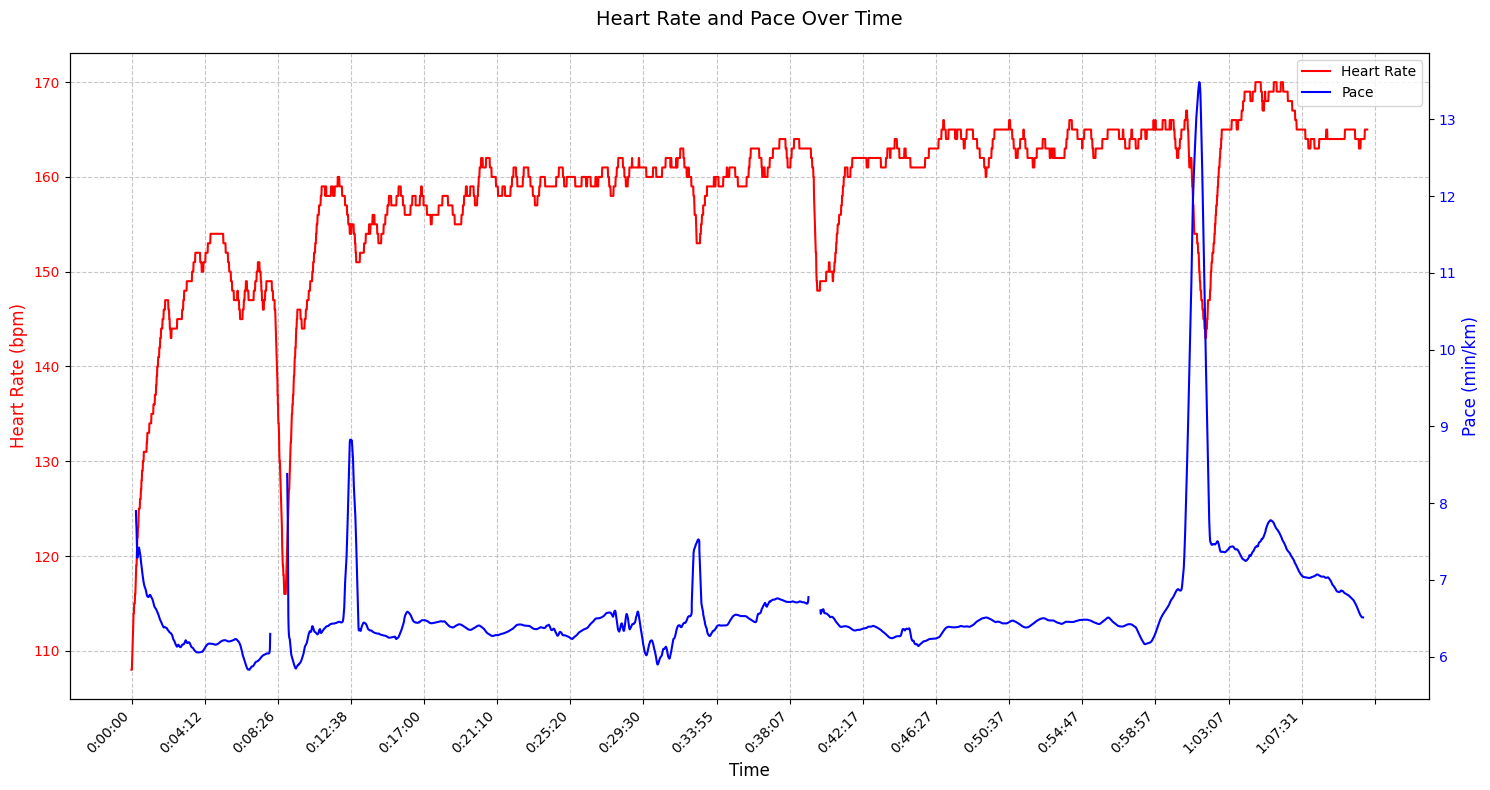

In [31]:
from haversine import haversine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Calculate cumulative distance
def calculate_cumulative_distance(df):
    distances = [0]  # Start with 0
    
    # Calculate distance between consecutive points
    for i in range(1, len(df)):
        point1 = (df['latitude'].iloc[i-1], df['longitude'].iloc[i-1])
        point2 = (df['latitude'].iloc[i], df['longitude'].iloc[i])
        distance = haversine(point1, point2, unit='km')
        distances.append(distances[-1] + distance)
    
    return distances

# Calculate pace (min/km) from enhanced_speed (m/s)
def calculate_pace(speed_ms):
    # Convert m/s to min/km
    # 1. Convert m/s to km/h: speed_ms * (3600/1000)
    # 2. Convert km/h to min/km: 60/speed_kmh
    speed_kmh = speed_ms * (3600/1000)
    pace = np.where(speed_kmh > 0, 60/speed_kmh, np.nan)
    # Apply rolling mean to smooth the pace data
    return pd.Series(pace).rolling(window=30, center=True).mean()

# Format seconds to HH:MM:SS
def format_time(seconds):
    return str(timedelta(seconds=int(seconds)))

# Process the DataFrame
def process_activity_data(df):
    # Calculate distance and time
    df['distance'] = calculate_cumulative_distance(df)
    start_time = df['timestamp'].min()
    df['time_elapsed'] = (df['timestamp'] - start_time).dt.total_seconds() / 60
    df['time_formatted'] = df['time_elapsed'].apply(lambda x: format_time(x * 60))
    
    # Calculate pace from enhanced_speed
    df['pace'] = calculate_pace(df['enhanced_speed'])
    
    # Reorder columns
    cols = list(df.columns)
    new_cols = ['latitude', 'longitude', 'distance', 'lap', 'timestamp', 
                'time_elapsed', 'time_formatted', 'pace', 'heart_rate'] + \
               [col for col in cols if col not in ['latitude', 'longitude', 'distance', 'lap', 
                'timestamp', 'time_elapsed', 'time_formatted', 'pace', 'heart_rate']]
    return df[new_cols]

# Create visualization
def plot_activity_metrics(df):
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Plot heart rate
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=12)
    ax1.plot(df['time_formatted'], df['heart_rate'], color='red', label='Heart Rate')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Show only some x-axis labels to prevent overcrowding
    ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

    # Create second y-axis for pace
    ax2 = ax1.twinx()
    ax2.set_ylabel('Pace (min/km)', color='blue', fontsize=12)
    ax2.plot(df['time_formatted'], df['pace'], color='blue', label='Pace')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add grid
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Add title
    plt.title('Heart Rate and Pace Over Time', fontsize=14, pad=20)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

# Process the data
df_point = process_activity_data(df_point)

# Create the visualization
plot_activity_metrics(df_point)

In [35]:
activities_df = pd.read_csv('export_64383208/activities.csv')
print('Activities Dataframe Shape:', activities_df.shape)
activities_df.head()

Activities Dataframe Shape: (335, 94)


,ID de l'activité,Date de l'activité,Nom de l'activité,Type d'activité,Description de l'activité,Temps écoulé,Distance,Fréquence cardiaque max.,Mesure d'effort,Déplacement-transport,...,Nombre d'activités,Nombre total de pas,CO2 économisé,Longueur de piscine,Charge d’entraînement,Intensité,Vitesse moyenne ajustée selon la pente,Temps enregistré par le chronomètre,Nombre total de cycles,Support
0,8160896480,23 nov. 2022 à 18:37:19,Marche en soirée,Marche,NaN,864,"1,15",172.0,8.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8180479096,28 nov. 2022 à 15:53:38,Course à pied dans l'après-midi,Course à pied,NaN,128,"0,28",155.0,0.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8180538494,28 nov. 2022 à 15:59:21,Course à pied dans l'après-midi,Course à pied,NaN,635,"2,03",180.0,13.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8235550009,11 déc. 2022 à 12:39:39,Course à pied dans l'après-midi,Course à pied,NaN,193,"0,45",159.0,1.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8235755229,11 déc. 2022 à 13:08:46,Course à pied dans l'après-midi,Course à pied,NaN,745,"2,02",183.0,15.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# List all columns in the dataframe
print("Features in the dataset:")
for col in activities_df.columns:
    print(f"- {col}")

Features in the dataset:
- ID de l'activité
- Date de l'activité
- Nom de l'activité
- Type d'activité
- Description de l'activité
- Temps écoulé
- Distance
- Fréquence cardiaque max.
- Mesure d'effort
- Déplacement-transport
- Note privée sur les activités
- Matériel utilisé pour l'activité
- Nom du fichier
- Poids de l'athlète
- Poids du vélo
- Temps écoulé.1
- Durée de déplacement
- Distance.1
- Vitesse max.
- Vitesse moyenne
- Dénivelé positif
- Dénivelé négatif
- Altitude min.
- Altitude max.
- Pente max.
- Pente moyenne
- Pente positive moyenne
- Pente négative moyenne
- Cadence max.
- Cadence moyenne
- Fréquence cardiaque max..1
- Fréquence cardiaque moyenne
- Puissance max.
- Puissance moyenne
- Calories
- Température max.
- Température moyenne
- Mesure d'effort.1
- Effort total
- Nombre de sorties course à pied
- Temps de montée
- Temps de descente
- Autres temps
- Effort ressenti
- Type
- Heure de début
- Puissance moyenne pondérée
- Nombre d'échantillons de puissance
- Utili

In [48]:
# Create a new DataFrame with selected features from activities_df
selected_features_activities = [
    'Nom du fichier',
    'ID de l\'activité',
    'Type d\'activité',
    'Temps écoulé',
    'Distance',
    'Mesure d\'effort',
    'Mesure d\'effort.1',
    'Vitesse max.',
    'Vitesse moyenne',
    'Dénivelé positif',
    'Dénivelé négatif',
    'Pente moyenne',
    'Fréquence cardiaque moyenne',
    'Fréquence cardiaque max.',
    'Charge d’entraînement',
    'Intensité'
]

activities_df_selected = activities_df[selected_features_activities].copy()


# Extract just the ID from the filename
activities_df_selected['Nom du fichier'] = activities_df_selected['Nom du fichier'].str.extract(r'activities/(\d+)\.fit')

# Display the shape and first few rows of the new DataFrame
print('Selected Features Activities DataFrame Shape:', activities_df_selected.shape)
activities_df_selected.head()



Selected Features Activities DataFrame Shape: (335, 16)


,Nom du fichier,ID de l'activité,Type d'activité,Temps écoulé,Distance,Mesure d'effort,Mesure d'effort.1,Vitesse max.,Vitesse moyenne,Dénivelé positif,Dénivelé négatif,Pente moyenne,Fréquence cardiaque moyenne,Fréquence cardiaque max.,Charge d’entraînement,Intensité
0,8740754330,8160896480,Marche,864,"1,15",8.0,8.0,2.020001,1.362073,13.656097,353.0,0.804220,135.943436,172.0,NaN,NaN
1,8762962338,8180479096,Course à pied,128,"0,28",0.0,0.0,2.960001,2.233600,3.790590,21.0,0.071633,137.968002,155.0,NaN,NaN
2,8763027094,8180538494,Course à pied,635,"2,03",13.0,13.0,3.960001,3.214225,26.415480,0.0,-0.177219,159.009491,180.0,NaN,NaN
3,8825346358,8235550009,Course à pied,193,"0,45",1.0,1.0,3.240000,2.385737,0.000000,41.0,0.022061,146.726318,159.0,NaN,NaN
4,8825580383,8235755229,Course à pied,745,"2,02",15.0,15.0,3.742017,2.727076,0.000000,132.0,0.000000,160.250671,183.0,NaN,NaN


In [49]:
# Filter for running activities (assuming the activity type is stored in a column like 'Type')
running_activities = activities_df_selected[activities_df_selected['Type d\'activité'] == 'Course à pied']

print('Running Activities Shape:', running_activities.shape)
running_activities.head()


Running Activities Shape: (209, 16)


,Nom du fichier,ID de l'activité,Type d'activité,Temps écoulé,Distance,Mesure d'effort,Mesure d'effort.1,Vitesse max.,Vitesse moyenne,Dénivelé positif,Dénivelé négatif,Pente moyenne,Fréquence cardiaque moyenne,Fréquence cardiaque max.,Charge d’entraînement,Intensité
1,8762962338,8180479096,Course à pied,128,"0,28",0.0,0.0,2.960001,2.233600,3.79059,21.0,0.071633,137.968002,155.0,NaN,NaN
2,8763027094,8180538494,Course à pied,635,"2,03",13.0,13.0,3.960001,3.214225,26.41548,0.0,-0.177219,159.009491,180.0,NaN,NaN
3,8825346358,8235550009,Course à pied,193,"0,45",1.0,1.0,3.240000,2.385737,0.00000,41.0,0.022061,146.726318,159.0,NaN,NaN
4,8825580383,8235755229,Course à pied,745,"2,02",15.0,15.0,3.742017,2.727076,0.00000,132.0,0.000000,160.250671,183.0,NaN,NaN
5,8825580349,8235755249,Course à pied,1090,"3,03",42.0,42.0,3.780029,2.791895,0.00000,175.0,-0.003295,175.677094,186.0,NaN,NaN


## FIND A BETTER WAY TO DO THIS (maybe each run in individual csv files with appropriate features ?)

In [50]:
time_series_data = []  # List to store processed time-series data

for activity_id in running_activities['Nom du fichier']:
    # Construct the file path
    fit_file_path = f"export_64383208/activities/{activity_id}.fit"
    
    try:
        # Convert FIT to DataFrames
        df_lap, df_point = conv.fit_to_dataframes(fname=fit_file_path)
        
        # Process time-series data
        df_point['activity_id'] = activity_id
        time_series_data.append(df_point)
        
    except Exception as e:
        print(f"Error processing file {fit_file_path}: {e}")


Error processing file export_64383208/activities/8762962338.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8763027094.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8825346358.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8825580383.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8825580349.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8883858231.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8906413713.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing file export_64383208/activities/8926156665.fit: '>=' not supported between instances of 'tuple' and 'int'
Error processing

KeyboardInterrupt: 

[]